# Four Multiplets (SI Figure 6)

In [1]:
# A few magic commands...
%load_ext autoreload
%autoreload 2
%matplotlib widget

## Defining the Experiment Info

In [2]:
import nmrespy as ne

offset = 0.0  # Hz
sw1 = 40.0  # Hz
sw2 = 1000.0  # Hz
pts1 = 128
pts2 = 8192
sfo = 500.0  # MHz
nucleus = "1H"

expinfo = ne.ExpInfo(
    dim=2,
    sw=(sw1, sw2),
    offset=(0., offset),
    pts=(pts1, pts2),
    sfo=(None, sfo),
    nuclei=(None, nucleus),
)

## Path Declarations

In [3]:
from pathlib import Path
import re

root = Path("../..")
name = "four-multiplets"
data_dir = root / "data" / name / "datasets"
output_dir = root / "code" / name / "output"

estimator_path_tmpl = str(output_dir / "estimator_{}.pkl")
output_dir.mkdir(exist_ok=True, parents=True)

data_paths = sorted([str(p) for p in data_dir.iterdir() if p.suffix == ".mat"])
estimator_paths = [
    Path(estimator_path_tmpl.format(re.search(r"dataset_(\d+)\.mat$", path).group(1)))
    for path in data_paths
]

## Creating and Saving the Estimator Objects

In [4]:
import copy
import numpy as np
from scipy.io import loadmat

estimators = []
for data_path, estimator_path in zip(data_paths, estimator_paths):
    if estimator_path.is_file():
        estimator = ne.Estimator2DJ.from_pickle(estimator_path)
    else: 
        fid = loadmat(str(data_path))["fid"].T
        # Add AWGN to with target SNR of 30 dB.
        fid = ne.sig.add_noise(fid, 30.0)
        # Create NMR-EsPy 2DJ estimatior object containing the FID and the experiment info.
        estimator = ne.Estimator2DJ(fid, copy.deepcopy(expinfo))
        # Add some exponential apodization
        estimator._data = ne.sig.exp_apodisation(estimator._data, k=3., axes=[0])
        estimator._data = ne.sig.exp_apodisation(estimator._data, k=7., axes=[1])
        # Spianch output is 90° phase shifted in the direct dimension. This needs to be corrected.
        estimator.phase_data(p0=0.5 * np.pi, p1=0.)
        estimator.to_pickle(estimator_path, force_overwrite=True)
        estimators.append(estimator)

Saved file ../../code/four-multiplets/output/estimator_1.pkl.
Saved file ../../code/four-multiplets/output/estimator_2.pkl.
Saved file ../../code/four-multiplets/output/estimator_3.pkl.
Saved file ../../code/four-multiplets/output/estimator_4.pkl.
Saved file ../../code/four-multiplets/output/estimator_5.pkl.


## Estimation

In [7]:
np.random.seed(0)

estimate_kwargs = dict(
    region=(35.0, -35.0),
    noise_region=(-400.0, -350.0),
    region_unit="hz",
    initial_guess=36,
)

rerun_estimation = False
for estimator, path in zip(estimators, estimator_paths):
    try:
        if rerun_estimation:
            raise ValueError("Re-running estimation.")
        estimator.get_results()
    except ValueError:
        estimator.estimate(**estimate_kwargs)
        estimator.to_pickle(path, force_overwrite=True)

┌───────────────────────────────────────┐
│ESTIMATING REGION: 35.0 - -35.0 Hz (F2)│
└───────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators has been pre-defined
	Number of oscillators: 36
--> Pencil parameters: 64, 40
--> Enhanced Block Hankel matrix constructed:
	Size: 2560 x 2600
	Memory: 101.5625MiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 7 secs, 397 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.164406     │ 0.916784     │ 1            │
│ 10    │ 0.05947

## Displaying the Results

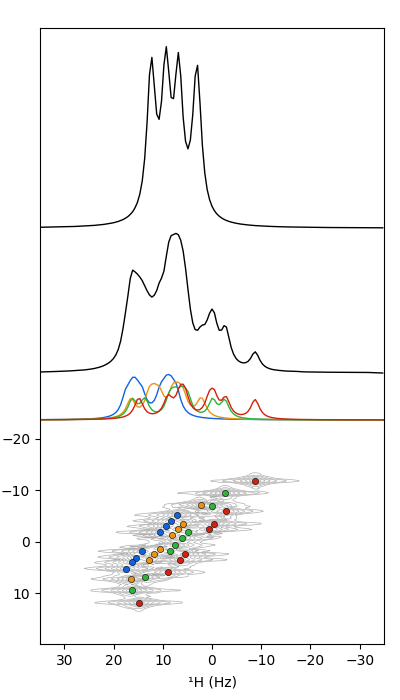

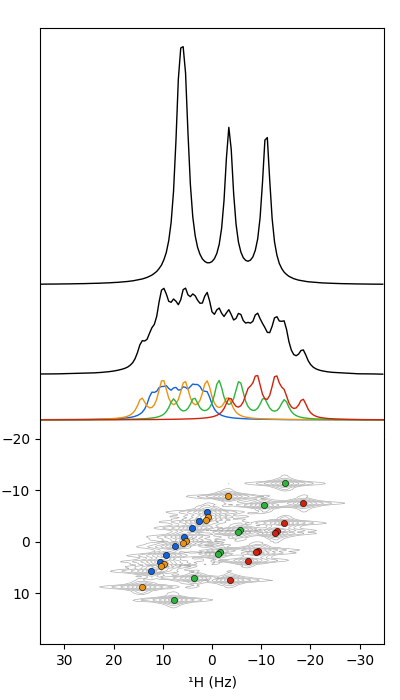

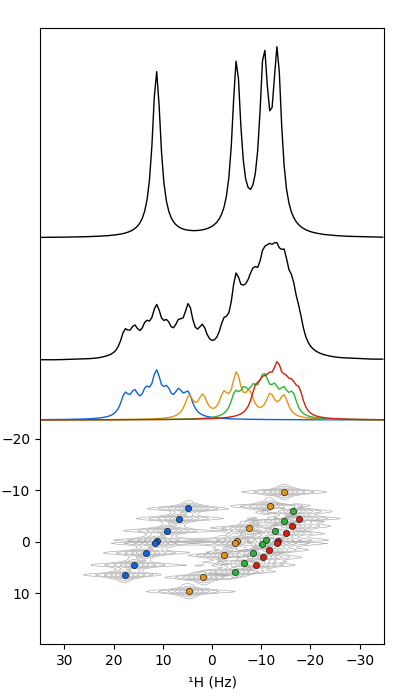

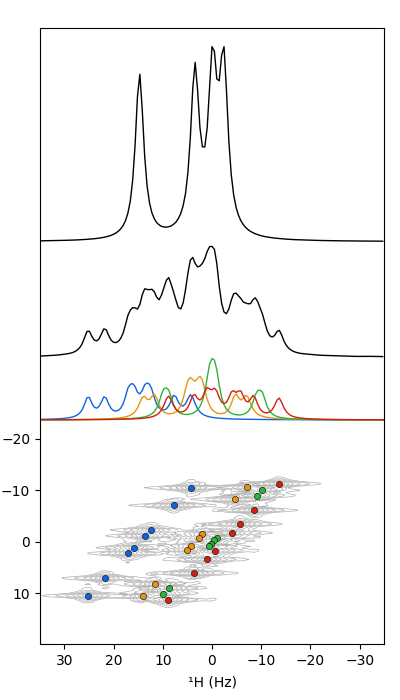

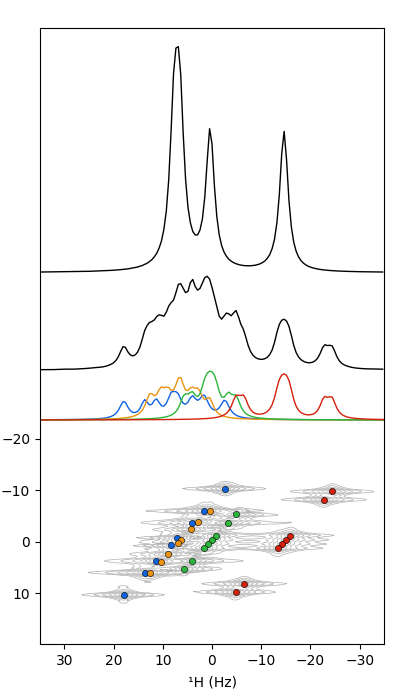

In [8]:
plot_kwargs = dict(
    multiplet_thold=0.5 * estimator.default_multiplet_thold,
    marker_size=20.0,
    contour_base=0.7,
    contour_factor=2.0,
    contour_nlevels=15,
    contour_color="#b0b0b0",
    figsize=(4.0, 7.0),
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
    axes_left=0.1,
)

figs = []
for estimator in estimators:
    figs.append(estimator.plot_result(**plot_kwargs))